In [ ]:
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

In [1]:
from google.colab import files
uploaded = files.upload()


Saving credit_risk_dataset.csv to credit_risk_dataset.csv


In [2]:
import io
import pandas as pd

df = pd.read_csv(io.StringIO(uploaded['credit_risk_dataset.csv'].decode('utf-8')))
df

person_age  ...  cb_person_cred_hist_length
0              22  ...                           3
1              21  ...                           2
2              25  ...                           3
3              23  ...                           2
4              24  ...                           4
...           ...  ...                         ...
32576          57  ...                          30
32577          54  ...                          19
32578          65  ...                          28
32579          56  ...                          26
32580          66  ...                          30

[32581 rows x 12 columns]

In [ ]:
import pandas_profiling
pr=df.profile_report()
pr

Summarize dataset:   0%|          | 0/25 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [26]:
import sklearn
import xgboost
import shap
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from category_encoders import TargetEncoder, OrdinalEncoder
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from scipy.stats import uniform, randint
from sklearn.metrics import auc, accuracy_score, confusion_matrix, roc_auc_score, classification_report
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
import shap
import matplotlib.pyplot as plt
from pdpbox import pdp

변수 설명

- erson_age : 대출 당시 나이
- person_income : 연간 소득
- person_home_ownership : 주택 소융 유형 (RENT / MORTGAGE / OWN / OTHER)
- person_emp_length : 일한 기간(연 단위)
- loan_intent : 대출 목적 ( EDUCATION / MEDICAL / VENTURE / PERSONAL/ DEBTCONSOLIDATION)
- loan_grade : 대출 등급 (A/B/C/D/E/F/G)
- loan_amnt : 대출 총액
- loan_int_rate : 이자율
- loan_percent_income : 연소득과 대출금의 비율
- cb_person_default_on_file : 과거 채무 불이행 여부
- cb_person_gist_length : 첫 대출 받은 후 지난 기간(연 단위)

**Target**

**- loan_stats : 0은 Non-default, 1은 default**

<데이터 선택 이유>

코로나로 인한 갑작스런 소득 감소와 초저금리 상황으로 가계 대출이 증가했고 대출 만기 연장, 이자 지불 유예 등의 정부 정책으로 인해 신용 부도 위험이 커진 상황이다. 이러한 현 상황에서 직접 부도 위험을 예측해보고 어떤 정보가 가장 상관성이 높은지 알고싶어서 선택했다.

<분석 목표>

이 분석을 통해서 신용 부도 위험을 예측해보고 부도 가능성을 예측하는데 가장 효과적인 지표를 알아본다


## Baselline

### 평가지표

- Accuracy : 전체 예측한 것중 맞게 예측한 비율
- AUC : ROC 곡선 아래 면적 (0.8 이상이면 좋은 모델)

In [4]:
# 타겟 데이터 비율 확인
df['loan_status'].value_counts(normalize=True)

0    0.781836
1    0.218164
Name: loan_status, dtype: float64

In [5]:
# 분류 문제 베이스 라인 설정
major = df['loan_status'].mode()[0]
baseline = [major] * len(df)

from sklearn.metrics import accuracy_score
print("baseline accuracy : ", accuracy_score(df['loan_status'], baseline))
print ('baseline roc_auc_score ', roc_auc_score(df['loan_status'], baseline))

baseline accuracy :  0.7818360394094718
baseline roc_auc_score  0.5


## Feature Engineering

In [6]:
# 'person_age' : 이상치 행에 -100 해주기
for i in range(len(df['person_age'])):
    if df['person_age'][i] > 100:
        df['person_age'][i] -= 100
    else:
        continue

# 'person_age' : 대부분 20대~50대 / 60세 이상 데이터는 80개 뿐으로 제외
df = df[df['person_age']<60]

# 'person_income' : 대부분 300000 이하 / 300000 이상 제외
df = df[df['person_income']<300000]

# 'cb_person_default_on_file' Y = 1, N = 0
df['cb_person_default_on_file'] = df['cb_person_default_on_file'].replace('Y',1)
df['cb_person_default_on_file'] = df['cb_person_default_on_file'].replace('N',0)

# 'per_emp_length' : 결측치를 중앙 값으로 대체 및 범위 조정
df['person_emp_length'] = df['person_emp_length'].fillna(df['person_emp_length'].median())
df = df[df['person_emp_length']<=30]

# 'loan_int_rate' : 결측치는 중앙값
df['loan_int_rate'] = df['loan_int_rate'].fillna(df['loan_int_rate'].median())

# 'loan_grade' : Ordinal Encoding
temp_dict = {"A": 7, "B": 6, "C": 5, "D": 4, "E" : 3, "F" : 2, "G" : 1}
df["loan_grade"] = df['loan_grade'].map(temp_dict)

# 월급 컬럼 생성
df['month_income'] = df['person_income'] / 12
df['month_income'] = df['month_income'].astype(int)

# 'person_home_ownership' , 'loan_intent' : One-hot-Encoding
df = pd.get_dummies(df)

In [51]:
# 'person_age' 컬럼에 144,123 이상치 확인
df['person_age'].unique()

array([ 22,  21,  25,  23,  24,  26, 144, 123,  20,  32,  34,  29,  33,
        28,  35,  31,  27,  30,  36,  40,  50,  45,  37,  39,  44,  43,
        41,  46,  38,  47,  42,  48,  49,  58,  65,  51,  53,  66,  61,
        54,  57,  59,  62,  60,  55,  52,  64,  70,  78,  69,  56,  73,
        63,  94,  80,  84,  76,  67])

In [52]:
# 이상치 행에 -100 해주기
for i in range(len(df['person_age'])):
    if df['person_age'][i] > 100:
        df['person_age'][i] -= 100
    else:
        continue

# 대부분 20대~50대 / 60세 이상 데이터는 80개 뿐으로 제외
df = df[df['person_age']<60]

# 'person_age' 컬럼 전처리 결과 확인
df['person_age'].unique()

array([22, 21, 25, 23, 24, 26, 44, 20, 32, 34, 29, 33, 28, 35, 31, 27, 30,
       36, 40, 50, 45, 37, 39, 43, 41, 46, 38, 47, 42, 48, 49, 58, 51, 53,
       54, 57, 59, 55, 52, 56])

In [53]:
# 'person_income' 확인
df['person_income'].sort_values()

31930       4000
15964       4080
15963       4200
27896       4200
15962       4800
          ...   
17833    1200000
31922    1362000
31924    1440000
30049    2039784
32297    6000000
Name: person_income, Length: 32501, dtype: int64

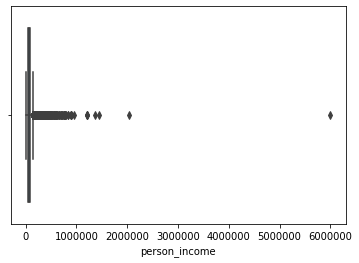

In [54]:
# 'person_income' 이상치 촥인
import seaborn as sns
import matplotlib.pyplot as plt
sns.boxplot(df['person_income'])

In [55]:
# 범위 조정 필요
df.sort_values(by = 'person_income', ascending = False).head(10)

person_age  ...  cb_person_cred_hist_length
32297          44  ...                          25
30049          42  ...                          15
31924          44  ...                          15
31922          47  ...                          17
29120          40  ...                          16
29119          36  ...                          11
17833          32  ...                           8
17834          34  ...                           7
32298          58  ...                          28
29122          36  ...                          12

[10 rows x 12 columns]

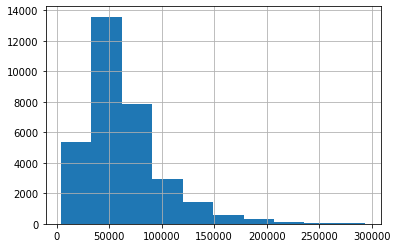

In [56]:
# 대부분 300000 이하 / 300000 이상 제외
df = df[df['person_income']<300000]
df['person_income'].hist()

In [57]:
# 'cb_person_default_on_file' Y = 1, N = 0

df['cb_person_default_on_file'] = df['cb_person_default_on_file'].replace('Y',1)
df['cb_person_default_on_file'] = df['cb_person_default_on_file'].replace('N',0)
df['cb_person_default_on_file']

0        1
1        0
2        0
3        0
4        1
        ..
32574    1
32575    0
32576    0
32577    0
32579    0
Name: cb_person_default_on_file, Length: 32336, dtype: int64

In [58]:
# 'person_emp_length' 이상치 및 결측치
df.sort_values(by = 'person_emp_length', ascending= False)

person_age  ...  cb_person_cred_hist_length
0              22  ...                           3
210            21  ...                           4
32515          53  ...                          23
32428          58  ...                          24
30914          48  ...                          17
...           ...  ...                         ...
32274          38  ...                          14
32285          38  ...                          12
32328          51  ...                          20
32453          56  ...                          18
32471          53  ...                          27

[32336 rows x 12 columns]

In [59]:
# 'per_emp_length' 가 nan인 사람들은 모두 중앙값 대체

df['person_emp_length'] = df['person_emp_length'].fillna(df['person_emp_length'].median())
df.sort_values(by = 'person_emp_length', ascending= False)

person_age  ...  cb_person_cred_hist_length
0              22  ...                           3
210            21  ...                           4
32515          53  ...                          23
32428          58  ...                          24
31867          46  ...                          11
...           ...  ...                         ...
3077           22  ...                           2
8858           22  ...                           3
18668          34  ...                           5
18669          27  ...                           7
13036          24  ...                           3

[32336 rows x 12 columns]

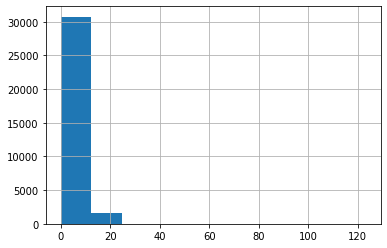

In [60]:
df['person_emp_length'].hist()

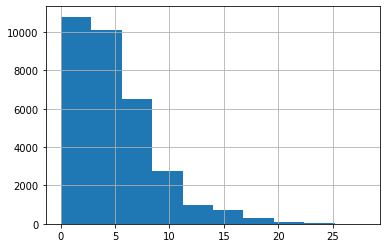

In [61]:
df = df[df['person_emp_length']<=30]
df['person_emp_length'].hist()

In [62]:
# 'loan_int_rate' 결측치는 중앙값으로 / 대출등급이 낮을수록 높은 이자율
df['loan_int_rate'] = df['loan_int_rate'].fillna(df['loan_int_rate'].median())

person_age  ...  cb_person_cred_hist_length
29277          38  ...                          12
27851          28  ...                           9
27425          28  ...                           8
13499          26  ...                           2
6449           23  ...                           3
...           ...  ...                         ...
32510          55  ...                          30
32547          53  ...                          28
32553          54  ...                          28
32569          51  ...                          23
32570          58  ...                          23

[32328 rows x 12 columns]

In [64]:
# 'loan_grade'
from category_encoders import OrdinalEncoder
temp_dict = {"A": 7, "B": 6, "C": 5, "D": 4, "E" : 3, "F" : 2, "G" : 1}
df["loan_grade"] = df['loan_grade'].map(temp_dict)
df['loan_grade'].unique()

array([6, 5, 7, 4, 3, 2, 1])

In [65]:
# 월급 컬럼 생성
df['month_income'] = df['person_income'] / 12
df['month_income'] = df['month_income'].astype(int)
df

person_age  person_income  ... cb_person_cred_hist_length  month_income
1              21           9600  ...                          2           800
2              25           9600  ...                          3           800
3              23          65500  ...                          2          5458
4              24          54400  ...                          4          4533
5              21           9900  ...                          2           825
...           ...            ...  ...                        ...           ...
32574          52          65004  ...                         19          5417
32575          52          64500  ...                         20          5375
32576          57          53000  ...                         30          4416
32577          54         120000  ...                         19         10000
32579          56         150000  ...                         26         12500

[32328 rows x 13 columns]

In [66]:
df.dtypes

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                      int64
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file       int64
cb_person_cred_hist_length      int64
month_income                    int64
dtype: object

In [70]:
df = pd.get_dummies(df)
df

person_age  person_income  ...  loan_intent_PERSONAL  loan_intent_VENTURE
1              21           9600  ...                     0                    0
2              25           9600  ...                     0                    0
3              23          65500  ...                     0                    0
4              24          54400  ...                     0                    0
5              21           9900  ...                     0                    1
...           ...            ...  ...                   ...                  ...
32574          52          65004  ...                     1                    0
32575          52          64500  ...                     0                    0
32576          57          53000  ...                     1                    0
32577          54         120000  ...                     1                    0
32579          56         150000  ...                     1                    0

[32328 rows x 21 columns]

In [7]:
df

person_age  person_income  ...  loan_intent_PERSONAL  loan_intent_VENTURE
1              21           9600  ...                     0                    0
2              25           9600  ...                     0                    0
3              23          65500  ...                     0                    0
4              24          54400  ...                     0                    0
5              21           9900  ...                     0                    1
...           ...            ...  ...                   ...                  ...
32574          52          65004  ...                     1                    0
32575          52          64500  ...                     0                    0
32576          57          53000  ...                     1                    0
32577          54         120000  ...                     1                    0
32579          56         150000  ...                     1                    0

[32328 rows x 21 columns]

## Modeling

In [8]:
# 타겟 설정 및 데이터 나누기
target = 'loan_status'
features = df.drop(columns= target).columns

train, test = train_test_split(df, test_size = 0.2, random_state = 2021, stratify = df[target])
train, val = train_test_split(train, test_size = 0.2, random_state = 2021, stratify = train[target])

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((20689, 20), (20689,), (5173, 20), (5173,), (6466, 20), (6466,))

### Model 1 . XGBClassifier

In [16]:
pipe = Pipeline([ 
                 ('xgb', XGBClassifier(eval_metric = 'auc', # auc
                                      random_state = 2021,
                                      objective = 'binary:logistic',
                                      n_jobs = -1))])

param = {   
            'xgb__n_estimators': randint(100,1000), 
            'xgb__learning_rate': uniform(0.01,1),
            'xgb__max_depth' : randint(3,10),
            'xgb__sub_sample' : uniform(0.01,1),
            'xgb__colsample_bytree': uniform(0.1,1),
            'xgb__scale_pos_weight' : uniform(0.1,1)}


clf = RandomizedSearchCV(
    pipe, 
    param_distributions=param, 
    n_iter=50, 
    cv=3, 
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train);

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 11.7min finished


In [17]:
print('Best Parameter :', clf.best_params_)
print('Best Score : ', (clf.best_score_))

Best Parameter : {'xgb__colsample_bytree': 0.934202848424697, 'xgb__learning_rate': 0.29153614727150423, 'xgb__max_depth': 8, 'xgb__n_estimators': 181, 'xgb__scale_pos_weight': 0.43538669692189247, 'xgb__sub_sample': 0.6067899847698456}
Best Score :  0.9340230575944505


In [18]:
model = clf.best_estimator_
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val) 


print ('accuracy socre', accuracy_score(y_val, y_pred_val))
print ('roc_auc_score ', roc_auc_score(y_val, y_pred_val))

accuracy socre 0.9338874927508216
roc_auc_score  0.8605866299522564


### Model 2. Random Forest

In [ ]:
pipe2 = Pipeline([
                 ('preprocessing', TargetEncoder()),
                 ('rf', RandomForestClassifier(
                                      random_state = 2021,
                                      class_weight='balanced',
                                      n_jobs = -1))])

param2 = {  'preprocessing__smoothing': [50.,100.,300.,500.,800.,1000.], 
            'preprocessing__min_samples_leaf': randint(1, 10),
            'rf__n_estimators': randint(100,500), 
            'rf__max_depth' : randint(3,10),
            'rf__min_samples_split' : randint(3,20),
            'rf__min_samples_leaf': randint(3,20),
            }


clf2 = RandomizedSearchCV(
    pipe2, 
    param_distributions=param2, 
    n_iter=50, 
    cv=3, 
    verbose=1,
    n_jobs=-1
)

clf2.fit(X_train, y_train);

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  4.2min finished
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


In [ ]:
print('Best Parameter :', clf2.best_params_)
print('Best Score : ', (clf2.best_score_))

Best Parameter : {'preprocessing__min_samples_leaf': 3, 'preprocessing__smoothing': 300.0, 'rf__max_depth': 9, 'rf__min_samples_leaf': 3, 'rf__min_samples_split': 16, 'rf__n_estimators': 160}
Best Score :  0.9090338884353028


In [ ]:
model2 = clf2.best_estimator_
y_pred_train2 = model2.predict(X_train)
y_pred_val2 = model2.predict(X_val)

print ('accuracy socre', accuracy_score(y_val, y_pred_val2))
print ('roc_auc_score ', roc_auc_score(y_val, y_pred_val2))

accuracy socre 0.9133964817320703
roc_auc_score  0.8548093893550508


### Model 3. LightGBM

In [10]:
pipe3 = Pipeline([
                 ('preprocessing', OrdinalEncoder()),
                 ('lgbm', LGBMClassifier(
                                      random_state = 2021,
                                      objective = 'binary',
                                      eval_metric = 'auc',
                                      n_jobs = -1))])

param3 = {   
            'lgbm__n_estimators': randint(100,1000), 
            'lgbm__learning_rate': uniform(0.01,0.2),
            'lgbm__max_depth' : randint(3,10),
            'lgbm__boosting' : ['gbdt','rf','dart','goss'],
            'lgbm__colsample_bytree': uniform(0.1,1),
            'lgbm__scale_pos_weight' : uniform(0.1,1)}


clf3 = RandomizedSearchCV(
    pipe3, 
    param_distributions=param3, 
    n_iter=50, 
    cv=3, 
    verbose=1,
    n_jobs=-1
)

clf3.fit(X_train, y_train);

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  4.5min finished


In [11]:
print('Best Parameter :', clf3.best_params_)
print('Best Score : ', (clf3.best_score_))

Best Parameter : {'lgbm__boosting': 'dart', 'lgbm__colsample_bytree': 0.9507296103172398, 'lgbm__learning_rate': 0.08830475368706482, 'lgbm__max_depth': 6, 'lgbm__n_estimators': 543, 'lgbm__scale_pos_weight': 0.8726676089207351}
Best Score :  0.9356180800780818


In [12]:
model3 = clf3.best_estimator_
y_pred_train3 = model3.predict(X_train)
y_pred_val3 = model3.predict(X_val)

print ('accuracy socre', accuracy_score(y_val, y_pred_val3))
print ('roc_auc_score ', roc_auc_score(y_val, y_pred_val3))

accuracy socre 0.935240672723758
roc_auc_score  0.8557215987218206


### Model 1 . XGBClassifier 의 성능이 가장 좋으로 test 데이터 적용

In [19]:
model = clf.best_estimator_
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)


print ('accuracy socre', accuracy_score(y_test, y_pred_test))
print ('roc_auc_score ', roc_auc_score(y_test, y_pred_test))

accuracy socre 0.9393751933188988
roc_auc_score  0.8718262180815978


이 모델은 개인의 정보를 토대로 신용 부도를 예측할 수 있다.

성능의 모델을 더욱 개선시키기 위해서는 더 다양한 정보가 필요하다


## 시각화

### Shap

In [20]:
#encoder = model.named_steps['preprocessing']
#X_test_en = model.named_steps['preprocessing'].transform(X_val)
xgb = model.named_steps['xgb']
test_id = X_test.index

In [77]:
y_pred_proba = xgb.predict_proba(X_test)[:,1]

In [78]:
row = X_test.iloc[[200]]
xgb.predict(row)

array([1])

In [111]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=row,
    link = 'logit'
)

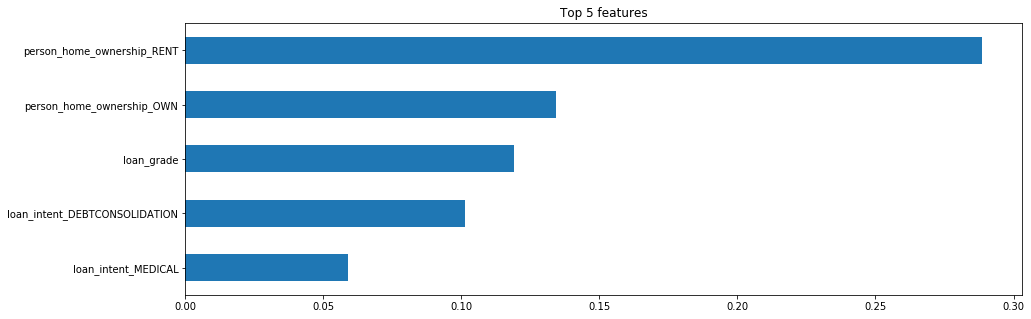

In [21]:
importances = pd.Series(xgb.feature_importances_, X_train.columns)

n = 5
plt.figure(figsize=(15,n))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();



## PDP

In [40]:
 df

person_age  person_income  ...  loan_grade_F  loan_grade_G
1              21           9600  ...             0             0
2              25           9600  ...             0             0
3              23          65500  ...             0             0
4              24          54400  ...             0             0
5              21           9900  ...             0             0
...           ...            ...  ...           ...           ...
32574          52          65004  ...             0             0
32575          52          64500  ...             0             0
32576          57          53000  ...             0             0
32577          54         120000  ...             0             0
32579          56         150000  ...             0             0

[32328 rows x 27 columns]

In [127]:
df.corr()

person_age  ...  loan_intent_VENTURE
person_age                        1.000000  ...            -0.009279
person_income                     0.108857  ...             0.008117
person_emp_length                 0.169955  ...             0.010864
loan_grade                       -0.010475  ...             0.010643
loan_amnt                         0.043304  ...            -0.000154
loan_int_rate                     0.009547  ...            -0.008410
loan_status                      -0.022593  ...            -0.078070
loan_percent_income              -0.038964  ...             0.001312
cb_person_default_on_file         0.002115  ...            -0.003133
cb_person_cred_hist_length        0.872300  ...            -0.005170
month_income                      0.108856  ...             0.008117
person_home_ownership_MORTGAGE    0.034629  ...            -0.020460
person_home_ownership_OTHER      -0.010408  ...             0.010756
person_home_ownership_OWN         0.000078  ...             0.099672
person_home_ownership_RENT       -0.032941  ...            -0.034939
loan_intent_DEBTCONSOLIDATION    -0.005473  ...            -0.201542
loan_intent_EDUCATION            -0.092163  ...            -0.230126
loan_intent_HOMEIMPROVEMENT       0.084182  ...            -0.162924
loan_intent_MEDICAL               0.016358  ...            -0.220878
loan_intent_PERSONAL              0.025501  ...            -0.208142
loan_intent_VENTURE              -0.009279  ...             1.000000

[21 rows x 21 columns]

<Figure size 720x720 with 0 Axes>

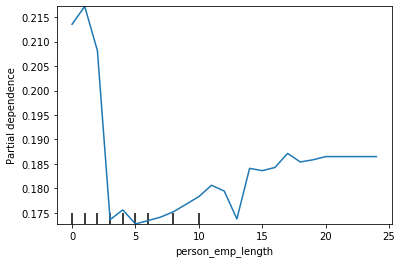

In [147]:
from sklearn.inspection import plot_partial_dependence
plt.figure(figsize=(10,10))
plot_partial_dependence(model, X_test, features= ['person_emp_length'], target = target )

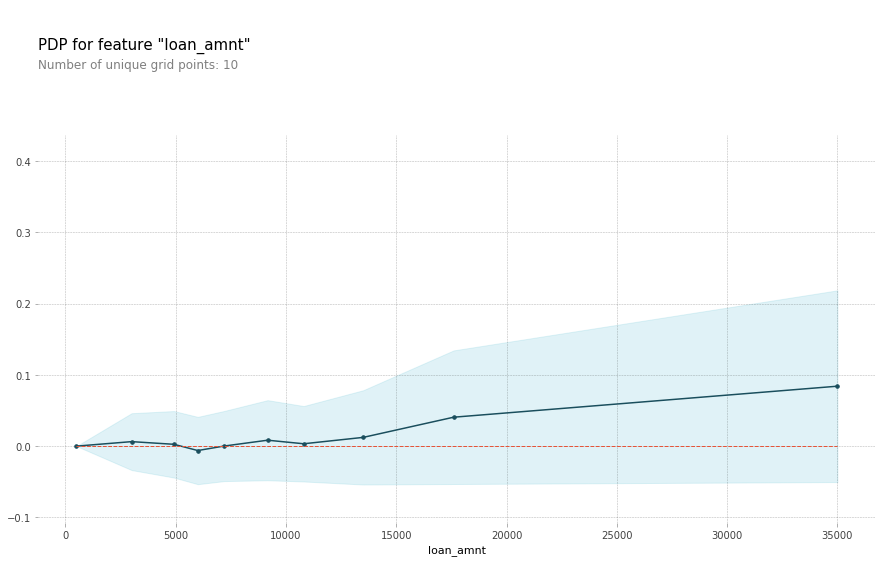

In [84]:
# 1. 대출 총액
feature = 'loan_amnt'
features = X_test.columns
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature);

대출 금액이 클수록 신용 부도의 확률이 높아진다.

(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f5f01809490>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f5f0187dc50>})

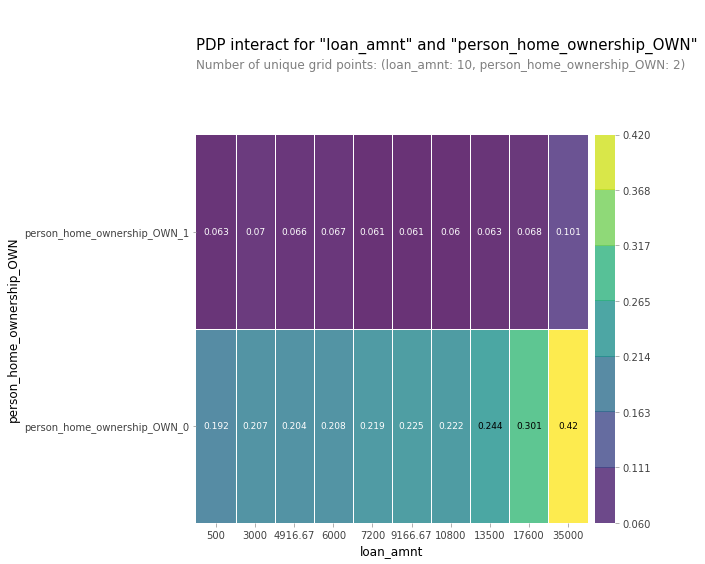

In [54]:
features = ['loan_amnt', 'person_home_ownership_OWN' ]
interaction = pdp_interact(
    model=model, 
    dataset=X_test, 
    model_features=X_test.columns, 
    features=features
)
pdp_interact_plot(interaction, plot_type='grid', feature_names=features)

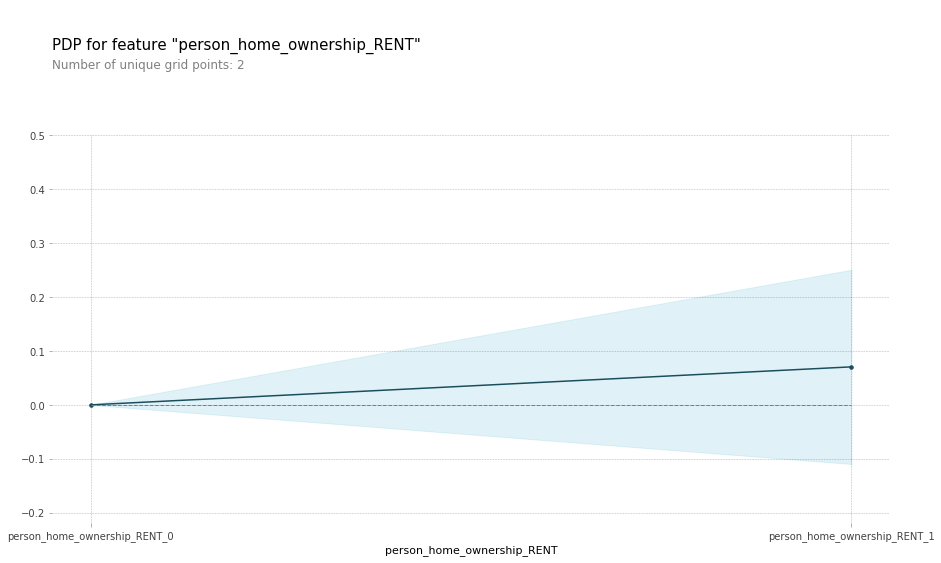

In [99]:

feature = 'person_home_ownership_RNET'
features = X_test.columns
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature);

집을 렌트 형식으로 사는 사람일수록 부도위험이 높다.

(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f5f030ecd90>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f5f031d82d0>})

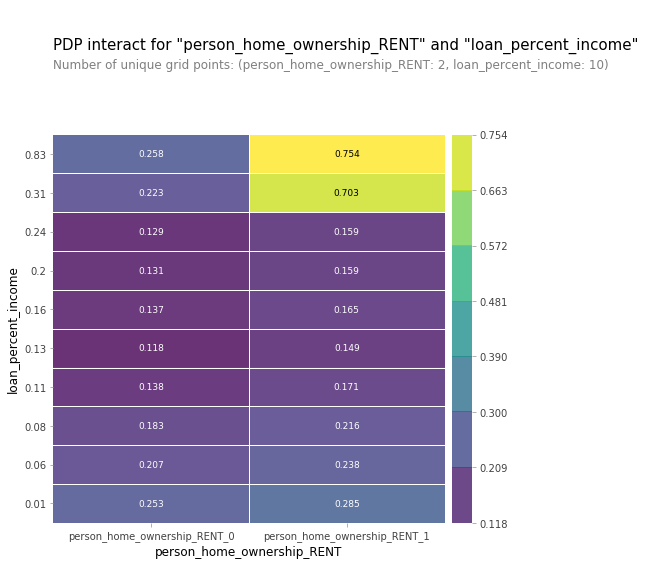

In [28]:
features = ['person_home_ownership_RENT', 'loan_percent_income' ]
interaction = pdp_interact(
    model=model, 
    dataset=X_test, 
    model_features=X_test.columns, 
    features=features
)
pdp_interact_plot(interaction, plot_type='grid', feature_names=features)

집을 RENT 형태로 소유하고 있는 사람들 중, 소득 대비 부채 비율이 높을수록

In [22]:
df

person_age  person_income  ...  loan_intent_PERSONAL  loan_intent_VENTURE
1              21           9600  ...                     0                    0
2              25           9600  ...                     0                    0
3              23          65500  ...                     0                    0
4              24          54400  ...                     0                    0
5              21           9900  ...                     0                    1
...           ...            ...  ...                   ...                  ...
32574          52          65004  ...                     1                    0
32575          52          64500  ...                     0                    0
32576          57          53000  ...                     1                    0
32577          54         120000  ...                     1                    0
32579          56         150000  ...                     1                    0

[32328 rows x 21 columns]

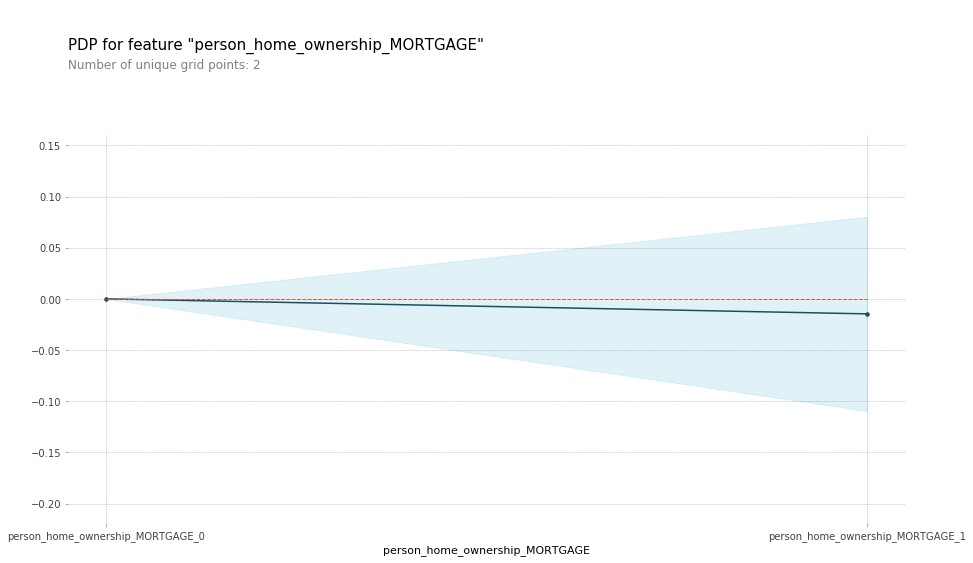

In [31]:

feature = 'person_home_ownership_MORTGAGE'
features = X_test.columns
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature);

### 가장 부도 위험이 높은 고객 유형

(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f767a0bfdd0>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f767bd300d0>})

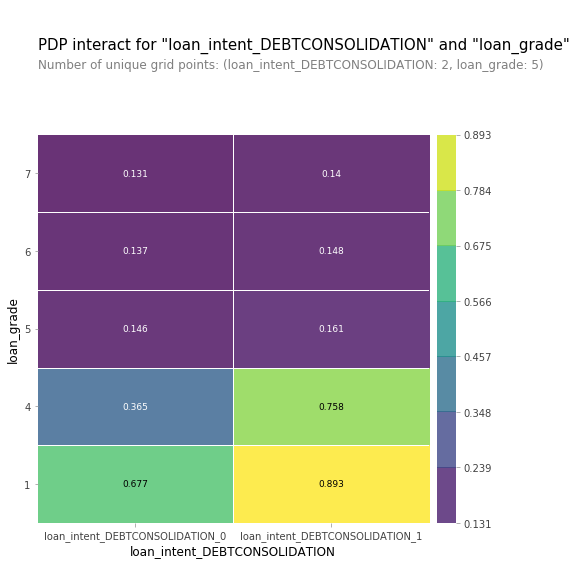

In [149]:
features = ['loan_intent_DEBTCONSOLIDATION', 'loan_grade' ]
interaction = pdp_interact(
    model=model, 
    dataset=X_test, 
    model_features=X_test.columns, 
    features=features
)
pdp_interact_plot(interaction, plot_type='grid', feature_names=features)

부채 통합을 의도로 대출을 하는 고객중 등급이 낮을수록 부도위험이 가장 높게 나타났다.

(0, 7)

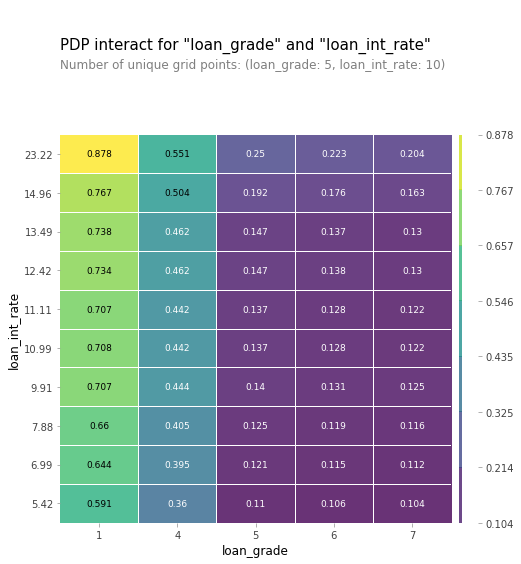

In [90]:
features = ['loan_grade', 'loan_int_rate' ]
interaction = pdp_interact(
    model=model, 
    dataset=X_test, 
    model_features=X_test.columns, 
    features=features
)
pdp_interact_plot(interaction, plot_type='grid', feature_names=features)
plt.xlim([0, 7])

이자율이 높고 대출 등급이 낮을수록 부도 확률이 높다.

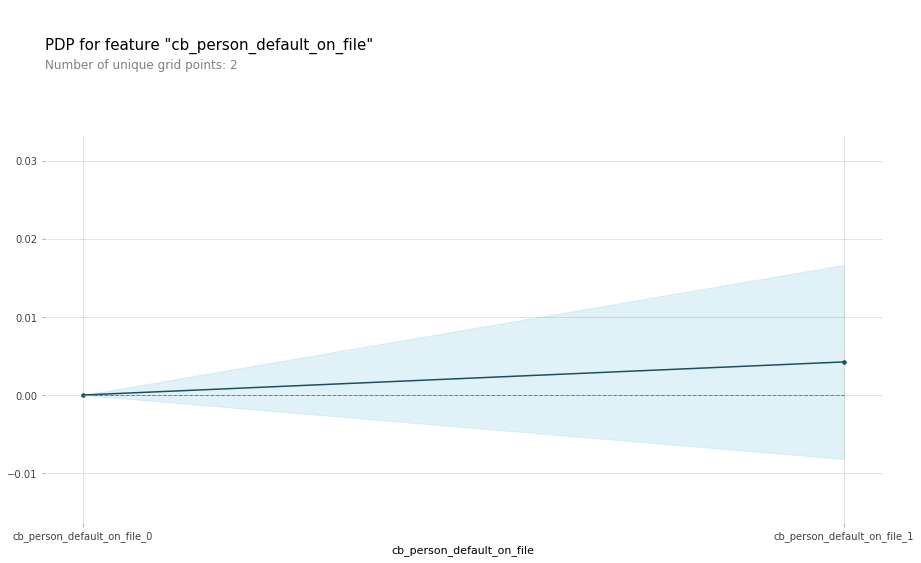

In [104]:
feature = 'cb_person_default_on_file'
features = X_test.columns
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature);

(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f5f01c15cd0>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f5f01d8f610>})

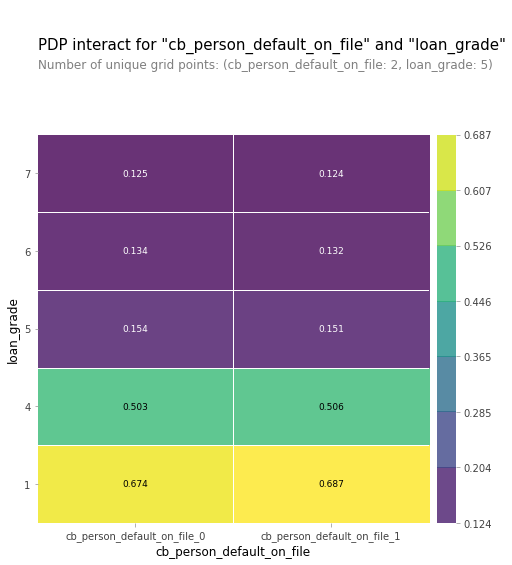

In [51]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot
features = ['cb_person_default_on_file', 'loan_grade']
interaction = pdp_interact(
    model=model, 
    dataset=X_test, 
    model_features=X_test.columns, 
    features=features
)
pdp_interact_plot(interaction, plot_type='grid', feature_names=features)

(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f92bbabdd10>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f92bbe09290>})

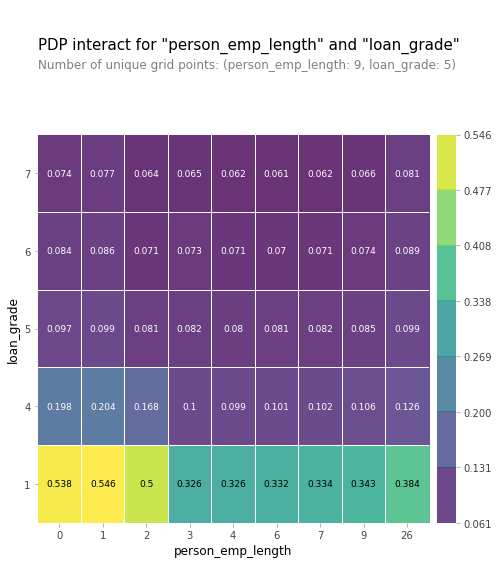

In [ ]:
features = ['person_emp_length', 'loan_grade']
interaction = pdp_interact(
    model=model, 
    dataset=X_test_en, 
    model_features=X_test_en.columns, 
    features=features
)
pdp_interact_plot(interaction, plot_type='grid', feature_names=features)

In [91]:
df.corr()

person_age  ...  loan_intent_VENTURE
person_age                        1.000000  ...            -0.009279
person_income                     0.108857  ...             0.008117
person_emp_length                 0.169955  ...             0.010864
loan_grade                       -0.010475  ...             0.010643
loan_amnt                         0.043304  ...            -0.000154
loan_int_rate                     0.009547  ...            -0.008410
loan_status                      -0.022593  ...            -0.078070
loan_percent_income              -0.038964  ...             0.001312
cb_person_default_on_file         0.002115  ...            -0.003133
cb_person_cred_hist_length        0.872300  ...            -0.005170
month_income                      0.108856  ...             0.008117
person_home_ownership_MORTGAGE    0.034629  ...            -0.020460
person_home_ownership_OTHER      -0.010408  ...             0.010756
person_home_ownership_OWN         0.000078  ...             0.099672
person_home_ownership_RENT       -0.032941  ...            -0.034939
loan_intent_DEBTCONSOLIDATION    -0.005473  ...            -0.201542
loan_intent_EDUCATION            -0.092163  ...            -0.230126
loan_intent_HOMEIMPROVEMENT       0.084182  ...            -0.162924
loan_intent_MEDICAL               0.016358  ...            -0.220878
loan_intent_PERSONAL              0.025501  ...            -0.208142
loan_intent_VENTURE              -0.009279  ...             1.000000

[21 rows x 21 columns]

In [92]:
train.columns

Index(['person_age', 'person_income', 'person_emp_length', 'loan_grade',
       'loan_amnt', 'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length',
       'month_income', 'person_home_ownership_MORTGAGE',
       'person_home_ownership_OTHER', 'person_home_ownership_OWN',
       'person_home_ownership_RENT', 'loan_intent_DEBTCONSOLIDATION',
       'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT',
       'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE'],
      dtype='object')